# PreProcessing and Pipelines

This notebook will house preprocessing pipelines for the Boston Homes data. This will handle skewness, distribution shape, and scaling of the data. 

In [1]:
import numpy as np
import pandas as pd
import sklearn
import matplotlib.pyplot as plt
import seaborn as sns
sns.set()

In [2]:
from sklearn.preprocessing import StandardScaler, KBinsDiscretizer, PowerTransformer 
from sklearn.preprocessing import MinMaxScaler, PolynomialFeatures, QuantileTransformer, FunctionTransformer
from sklearn.pipeline import Pipeline, make_pipeline
from sklearn.model_selection import train_test_split, GridSearchCV, KFold, cross_val_score
from sklearn.metrics import mean_squared_error
from scipy import stats



# Preprocessing Pipelines

Let's establish some Preprocessing pipelines.

First, turn into guassian distribution by transforming with powertransformer, quantile
then apply Standard Scaler
then fix outliers with z-score fixing.


In [3]:
from sklearn.datasets import load_boston
data = load_boston()
X, y = pd.DataFrame(data['data'], columns = data.feature_names), pd.Series(data['target'], name='MEDV')
X.head()
print(y.head())

0    24.0
1    21.6
2    34.7
3    33.4
4    36.2
Name: MEDV, dtype: float64


In [4]:
X.head(3)

,CRIM,ZN,INDUS,CHAS,NOX,RM,AGE,DIS,RAD,TAX,PTRATIO,B,LSTAT
0,0.00632,18.0,2.31,0.0,0.538,6.575,65.2,4.0900,1.0,296.0,15.3,396.90,4.98
1,0.02731,0.0,7.07,0.0,0.469,6.421,78.9,4.9671,2.0,242.0,17.8,396.90,9.14
2,0.02729,0.0,7.07,0.0,0.469,7.185,61.1,4.9671,2.0,242.0,17.8,392.83,4.03


In [5]:
#make a copy of dataframe for safekeeping
X_copy = X.copy()

It is good practice to visualize the shape and distribution of the data before and after any preprocessing, so let's first remind ourselves, using examples from the EDA worksheet, what the data looks like

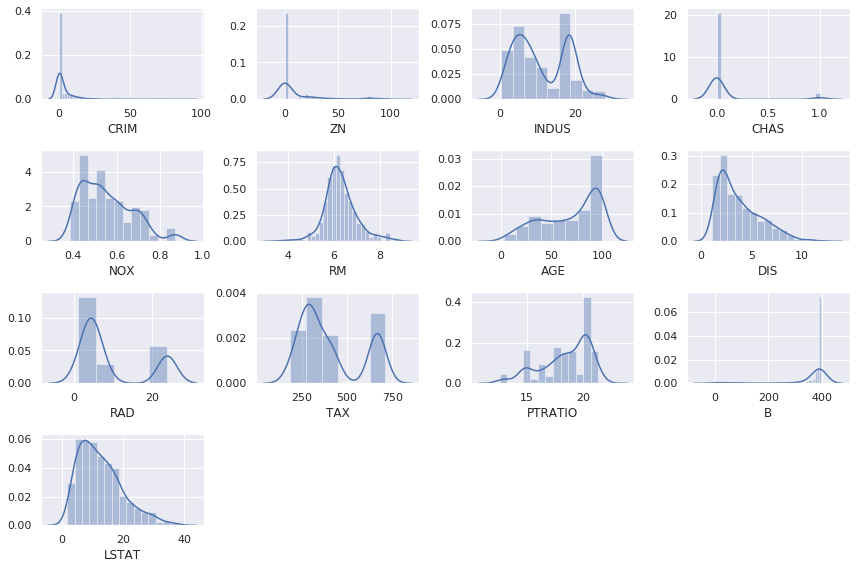

In [6]:
#custom function to display all features histogram shapes and kde shape overlay

def plot_hist(df, features, subplot_dimensions):
    '''Input: list of feature names, list of subplot dimensions'''
    fig = plt.figure(figsize = (12, 8))
    
    for idx, feature in enumerate(list(df[features])):
        idx += 1
        plt.subplot(subplot_dimensions[0], subplot_dimensions[1], idx)
        sns.distplot(df[feature])
        idx +=1
        
        plt.tight_layout()

plot_hist(X, list(X.columns), [4,4])  

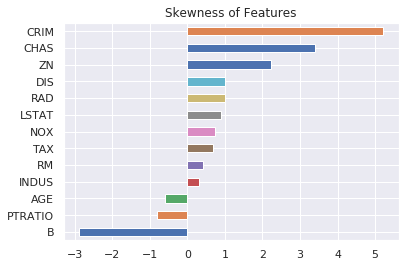

In [7]:
X.skew().sort_values(ascending=True).plot(kind = 'barh', title = "Skewness of Features")

Next, we'll designate which features are suitable for such transformations as above. Using insight from https://scikit-learn.org/stable/auto_examples/preprocessing/plot_map_data_to_normal.html#sphx-glr-auto-examples-preprocessing-plot-map-data-to-normal-py, here are some possible transformations for each feature:

- Log Transformations: CRIM, 
- Box-Cox or Neo-Johnson:
    NOX, AGE, DIS, PTRATIO, B, LSTAT
- Quantile:
    INDUS, RAD, TAX
- Quantization:
    ZN. Since there are a significant amount of 0 values, this feature will be binned in the following manner: 0 if ZN = 0, 1 if ZN >0 & <= .1, and 2 if ZN >.1
- No transformations needed:
    RM, CHAS. RM has anice gaussian shape to it, and CHAS is a logical variable, therefore there is no need to manipulate it. 
 
First, we'll quantize ZN. After, we will create dummy variables for each of the three classes.

Next, we'll apply a logarithmic transformation to CRIM to better approximate a Gaussian Distribution

Then, we will first use the transformations on respective features then use StandardScaler  to center and scale all features, then fix outliers using custom definition above, my_func.

In [8]:
#qauntize ZN
X['ZN'] = pd.cut(X['ZN'], [-0.01, .001, 10.0, 100.0], labels = ['0%', 'less_than_10%', 'greater_than_10%'])

#get dummy variables
X = pd.get_dummies(X,prefix = 'ZN', )

#apply log transformation to CRIM feature
def log_transformation(dataframe, columns):
    dataframe[columns] = np.log(dataframe[columns])
    return dataframe[columns]

X['CRIM'] = log_transformation(X, 'CRIM')
X.head(10)

,CRIM,INDUS,CHAS,NOX,RM,AGE,DIS,RAD,TAX,PTRATIO,B,LSTAT,ZN_0%,ZN_less_than_10%,ZN_greater_than_10%
0,-5.064036,2.31,0.0,0.538,6.575,65.2,4.0900,1.0,296.0,15.3,396.90,4.98,0,0,1
1,-3.600502,7.07,0.0,0.469,6.421,78.9,4.9671,2.0,242.0,17.8,396.90,9.14,1,0,0
2,-3.601235,7.07,0.0,0.469,7.185,61.1,4.9671,2.0,242.0,17.8,392.83,4.03,1,0,0
3,-3.430523,2.18,0.0,0.458,6.998,45.8,6.0622,3.0,222.0,18.7,394.63,2.94,1,0,0
4,-2.672924,2.18,0.0,0.458,7.147,54.2,6.0622,3.0,222.0,18.7,396.90,5.33,1,0,0
5,-3.511570,2.18,0.0,0.458,6.430,58.7,6.0622,3.0,222.0,18.7,394.12,5.21,1,0,0
6,-2.427128,7.87,0.0,0.524,6.012,66.6,5.5605,5.0,311.0,15.2,395.60,12.43,0,0,1
7,-1.934130,7.87,0.0,0.524,6.172,96.1,5.9505,5.0,311.0,15.2,396.90,19.15,0,0,1
8,-1.554760,7.87,0.0,0.524,5.631,100.0,6.0821,5.0,311.0,15.2,386.63,29.93,0,0,1
9,-1.771722,7.87,0.0,0.524,6.004,85.9,6.5921,5.0,311.0,15.2,386.71,17.10,0,0,1


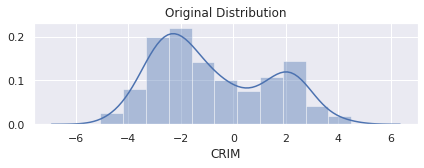

In [9]:
#look at CRIM distribution
plt.subplot(2,1,1, title = 'Original Distribution')
sns.distplot(X['CRIM'])

plt.tight_layout()

ANALYSIS NEEDED HERE

Now we procede with building a pipeline of transformations that correspond to particular features we designated earlier. 

Steps: 
- Neo J/Box-cox transformations with standardize=True, 
- Quantile transformations,
- StandardScale() to all features the apply
- Outlier handling with custom function, based on z-score value


In [10]:
#establish lists of features for correpsonding transformations

Neo_J_features = [ 'NOX', 'AGE', 'DIS', 
       'PTRATIO', 'B', 'LSTAT']

Quantile_features = ['INDUS', 'TAX', 'RAD' ]

#remainig feature, CRIM and RM has to match scaling of other features, 
#so we make a list for it  
features_to_scale = ['CRIM', 'RM']  

In [11]:
#establish Power transformations to be combined into a pipeline
#will help massage features into a more normal distribution
#box_cox = PowerTransformer(method= 'box-cox', standardize=True)
yeo_john = PowerTransformer(method = 'yeo-johnson', standardize=True)
quantile = QuantileTransformer(output_distribution='normal', random_state=777)
scaler = StandardScaler()



In [12]:
from sklearn.compose import ColumnTransformer

#establish the ColumnTransformer Pipeline

yeo_j_transformer = Pipeline(steps = [
    ('transformer_yj', yeo_john)
])

quantile_tranformer = Pipeline(steps = [
    ('transformer_q', quantile)
])

remaining_feat_transforer = Pipeline(steps = [
    ('scaler', scaler)
])

combined_preprocessor = ColumnTransformer(
    transformers = [
        ('yeo_j', yeo_j_transformer, Neo_J_features),
        ('quantile', quantile_tranformer, Quantile_features),
        ('scale', scaler, features_to_scale)
    ]
)

#last part of preprocessing: handling outliers
#simply replace any value with z-score above/below 3/-3 with 3, -3
def z_score_outliers(array):
    array = np.where(array > 3, 3, array)
    array = np.where(array < -3, -3, array)
    
    return array

#to comply with sklearn Pipeline
outlier_handle = FunctionTransformer(z_score_outliers)

In order to avoid manipulating data that should not be manipulated, (dummy variables, CHAS), we'll seperate out those features here and re-combine them after data manipulation has finished.

In [13]:
#set up training and testing splits
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = .25, random_state = 777)

In [18]:
X_train.head(10)

,CRIM,INDUS,CHAS,NOX,RM,AGE,DIS,RAD,TAX,PTRATIO,B,LSTAT,ZN_0%,ZN_less_than_10%,ZN_greater_than_10%
359,1.449577,18.10,0.0,0.770,6.112,81.3,2.5091,24.0,666.0,20.2,390.74,12.67,1,0,0
141,0.487745,21.89,0.0,0.624,5.019,100.0,1.4394,4.0,437.0,21.2,396.90,34.41,1,0,0
474,2.086391,18.10,0.0,0.584,5.427,95.4,2.4298,24.0,666.0,20.2,352.58,18.14,1,0,0
291,-2.540081,4.95,0.0,0.411,7.148,27.7,5.1167,4.0,245.0,19.2,396.90,3.56,0,0,1
396,1.770204,18.10,0.0,0.693,6.405,96.0,1.6768,24.0,666.0,20.2,396.90,19.37,1,0,0
424,2.173856,18.10,0.0,0.584,5.565,70.6,2.0635,24.0,666.0,20.2,3.65,17.16,1,0,0
349,-3.540804,1.25,0.0,0.429,6.939,34.5,8.7921,1.0,335.0,19.7,389.85,5.89,0,0,1
415,2.895061,18.10,0.0,0.679,6.434,100.0,1.8347,24.0,666.0,20.2,27.25,29.05,1,0,0
352,-2.624997,1.69,0.0,0.411,5.884,18.5,10.7103,4.0,411.0,18.3,392.33,7.79,0,0,1
234,-0.803163,6.20,1.0,0.507,6.726,66.5,3.6519,8.0,307.0,17.4,360.20,8.05,1,0,0


In [14]:
#data to be preprocessed
X_preprocess = X_train.loc[:,['NOX', 'AGE', 'DIS', 'PTRATIO', 'B', 'LSTAT',
    'INDUS', 'TAX', 'RAD', 'CRIM', 'RM']]
X_preprocess.head()

,NOX,AGE,DIS,PTRATIO,B,LSTAT,INDUS,TAX,RAD,CRIM,RM
359,0.770,81.3,2.5091,20.2,390.74,12.67,18.10,666.0,24.0,1.449577,6.112
141,0.624,100.0,1.4394,21.2,396.90,34.41,21.89,437.0,4.0,0.487745,5.019
474,0.584,95.4,2.4298,20.2,352.58,18.14,18.10,666.0,24.0,2.086391,5.427
291,0.411,27.7,5.1167,19.2,396.90,3.56,4.95,245.0,4.0,-2.540081,7.148
396,0.693,96.0,1.6768,20.2,396.90,19.37,18.10,666.0,24.0,1.770204,6.405


In [15]:
final_pipe = Pipeline(
    steps = [('combined_preprocessor', combined_preprocessor),
             ('outlier_handle', outlier_handle)
            ]
        )

transformed_data = final_pipe.fit_transform(X_preprocess)


/opt/tljh/user/lib/python3.6/site-packages/sklearn/preprocessing/_function_transformer.py:98: FutureWarning: The default validate=True will be replaced by validate=False in 0.22.
  "validate=False in 0.22.", FutureWarning)
/opt/tljh/user/lib/python3.6/site-packages/sklearn/preprocessing/_function_transformer.py:98: FutureWarning: The default validate=True will be replaced by validate=False in 0.22.
  "validate=False in 0.22.", FutureWarning)


In [16]:
#set the transformed data back to a dataframe 
#to be combined with excluded data
transformed_data = pd.DataFrame(transformed_data, columns=X_preprocess.columns)
transformed_data.head(10)

,NOX,AGE,DIS,PTRATIO,B,LSTAT,INDUS,TAX,RAD,CRIM,RM
0,1.671978,0.428610,-0.503334,0.816835,0.424241,0.244935,0.711981,1.031509,3.000000,1.031392,-0.254047
1,0.762388,1.194283,-1.579259,1.620672,0.645963,2.155771,1.738731,0.516356,-0.613509,0.589946,-1.824510
2,0.441863,1.001199,-0.566094,0.816835,-0.724794,0.894914,0.711981,1.031509,3.000000,1.323667,-1.238281
3,-1.485077,-1.414834,0.845916,0.150940,0.645963,-1.695375,-0.734798,-1.135284,-0.613509,-0.799718,1.234516
4,1.237170,1.026215,-1.288140,0.816835,0.645963,1.018209,0.711981,1.031509,3.000000,1.178548,0.166946
5,0.441863,0.014989,-0.885489,0.816835,-2.899512,0.791611,0.711981,1.031509,3.000000,1.363810,-1.039997
6,-1.232734,-1.217939,1.760168,0.467846,0.393098,-0.996860,-2.256745,-0.003764,-3.000000,-1.259014,0.934217
7,1.148007,1.194283,-1.114235,0.816835,-2.899450,1.809882,0.711981,1.031509,3.000000,1.694817,0.208614
8,-1.485077,-1.656934,2.061690,-0.345801,0.480434,-0.567531,-1.798663,0.384375,-0.613509,-0.838691,-0.581646
9,-0.291460,-0.138319,0.221722,-0.758183,-0.524149,-0.515266,-0.430727,-0.240671,0.527858,-0.002535,0.628171


In [25]:
#add back the excluded data onto this training split

for feature in ['CHAS','ZN_0%', 'ZN_less_than_10%',
                'ZN_greater_than_10%']:
    transformed_data.loc[:,feature] = X_train[feature].values

transformed_data.head(10)

,NOX,AGE,DIS,PTRATIO,B,LSTAT,INDUS,TAX,RAD,CRIM,RM,CHAS,ZN_0%,ZN_less_than_10%,ZN_greater_than_10%
0,1.671978,0.428610,-0.503334,0.816835,0.424241,0.244935,0.711981,1.031509,3.000000,1.031392,-0.254047,0.0,1,0,0
1,0.762388,1.194283,-1.579259,1.620672,0.645963,2.155771,1.738731,0.516356,-0.613509,0.589946,-1.824510,0.0,1,0,0
2,0.441863,1.001199,-0.566094,0.816835,-0.724794,0.894914,0.711981,1.031509,3.000000,1.323667,-1.238281,0.0,1,0,0
3,-1.485077,-1.414834,0.845916,0.150940,0.645963,-1.695375,-0.734798,-1.135284,-0.613509,-0.799718,1.234516,0.0,0,0,1
4,1.237170,1.026215,-1.288140,0.816835,0.645963,1.018209,0.711981,1.031509,3.000000,1.178548,0.166946,0.0,1,0,0
5,0.441863,0.014989,-0.885489,0.816835,-2.899512,0.791611,0.711981,1.031509,3.000000,1.363810,-1.039997,0.0,1,0,0
6,-1.232734,-1.217939,1.760168,0.467846,0.393098,-0.996860,-2.256745,-0.003764,-3.000000,-1.259014,0.934217,0.0,0,0,1
7,1.148007,1.194283,-1.114235,0.816835,-2.899450,1.809882,0.711981,1.031509,3.000000,1.694817,0.208614,0.0,1,0,0
8,-1.485077,-1.656934,2.061690,-0.345801,0.480434,-0.567531,-1.798663,0.384375,-0.613509,-0.838691,-0.581646,0.0,0,0,1
9,-0.291460,-0.138319,0.221722,-0.758183,-0.524149,-0.515266,-0.430727,-0.240671,0.527858,-0.002535,0.628171,1.0,1,0,0


In [24]:
#Build the classifier on the training data

from sklearn.ensemble import RandomForestRegressor

reg = RandomForestRegressor()

reg.fit(transformed_data, y_train)

/opt/tljh/user/lib/python3.6/site-packages/sklearn/ensemble/forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=None,
           max_features='auto', max_leaf_nodes=None,
           min_impurity_decrease=0.0, min_impurity_split=None,
           min_samples_leaf=1, min_samples_split=2,
           min_weight_fraction_leaf=0.0, n_estimators=10, n_jobs=None,
           oob_score=False, random_state=None, verbose=0, warm_start=False)

In [29]:
from sklearn.metrics import mean_squared_error
y_pred = reg.predict(X_test)

mse = mean_squared_error(y_test, y_pred)
rmse = np.sqrt(mean_squared_error(y_test, y_pred))

print(mse)
print(f" RMSE: {rmse}")
               
               


90.59949291338579
 RMSE: 9.518376590227232


In [28]:
#cross-validation of results

scores = cross_val_score(reg,transformed_data, y_train, cv=3, scoring = 'neg_mean_squared_error')

print(scores)
print("Mean Score: " + str(np.mean(scores)))
print("Std: " + str(np.std(scores)))

[-22.20232205 -10.22413492  -9.55546349]
Mean Score: -13.993973486647503
Std: 5.8105949172772915


In [70]:
from sklearn.linear_model import LinearRegression

reg = LinearRegression()

pipe = Pipeline([
    ('yeo', yeo_john),
    ('scale', scaler),
    ('outlier', my_func),
    ('reg', reg)  
                ])

pipe.fit(X_train, y_train)
y_pred = pipe.predict(X_test)

/opt/tljh/user/lib/python3.6/site-packages/sklearn/preprocessing/_function_transformer.py:98: FutureWarning: The default validate=True will be replaced by validate=False in 0.22.
  "validate=False in 0.22.", FutureWarning)
/opt/tljh/user/lib/python3.6/site-packages/sklearn/preprocessing/_function_transformer.py:98: FutureWarning: The default validate=True will be replaced by validate=False in 0.22.
  "validate=False in 0.22.", FutureWarning)
/opt/tljh/user/lib/python3.6/site-packages/sklearn/preprocessing/_function_transformer.py:98: FutureWarning: The default validate=True will be replaced by validate=False in 0.22.
  "validate=False in 0.22.", FutureWarning)


In [72]:
mean_squared_error(y_test, y_pred)

22.16750845883944

In [73]:
y_pred

array([16.57706385, 15.04822888, 14.73983914, 23.19941911, 35.21123251,
       18.56638904, 11.83571603, 46.1292165 , 13.60938717, 38.98806985,
       30.96580536, 28.62998342, 16.66637679, 18.84012537, 17.56877437,
       37.5834715 , 10.68305793, 20.61085772, 23.85854468, 16.282259  ,
       16.28260397, 18.18595234, 12.60427838, 30.02932614, 20.05279035,
       24.81123369, 23.22117603, 32.46635806, 22.24161938, 21.9451746 ,
       29.83617667, 30.56139346, 25.85748031, 32.15000915, 24.26241655,
       31.3780724 , 13.67074548, 23.6244546 , 20.17822929, 18.80427538,
       20.76699273, 17.68046   , 10.76375031, 18.8055579 , 13.88169002,
       22.55588355, 14.47030561, 24.02081307, 20.64925368, 18.56335508,
       31.72250172, 36.03056034, 18.66382105, 17.29408071, 22.41797222,
       26.69857404, 19.09263162, 19.81290634, 29.0579199 , 15.44858624,
       30.29898058, 18.28270987, 26.17170167, 18.85126965, 15.67771551,
       36.5896564 , 36.32481761, 17.42496027, 25.96481384, 14.72